<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: FELIPE GALAZ GARCIA
- Nombre de alumno 2: MIRKO MARTINIC JARA


### **Link de repositorio de GitHub:** `https://github.com/mmartinicj/MDS7202-labs`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [1]:
!pip install xgboost

In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [3]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.6 MB/s eta 0:00:00


In [4]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 3.0 MB/s eta 0:00:00


In [5]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
import shap
from alibi.explainers import AnchorTabular

# Pre-procesamiento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Metricas de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#Libreria para plotear
import seaborn as sns
from matplotlib import pyplot as plt

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [6]:
# import numpy as np
# import pandas as pd

# df = pd.read_csv('diabetes_data.csv')
# df.head(4)

In [7]:
#montar Google Drive
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [9]:
# !pip install xgboost

,count,mean,std,min,25%,50%,75%,max
Age,70692.0,8.584055,2.852153,1.0,7.0,9.0,11.0,13.0
Sex,70692.0,0.456997,0.498151,0.0,0.0,0.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0
Veggies,70692.0,0.788774,0.408181,0.0,1.0,1.0,1.0,1.0


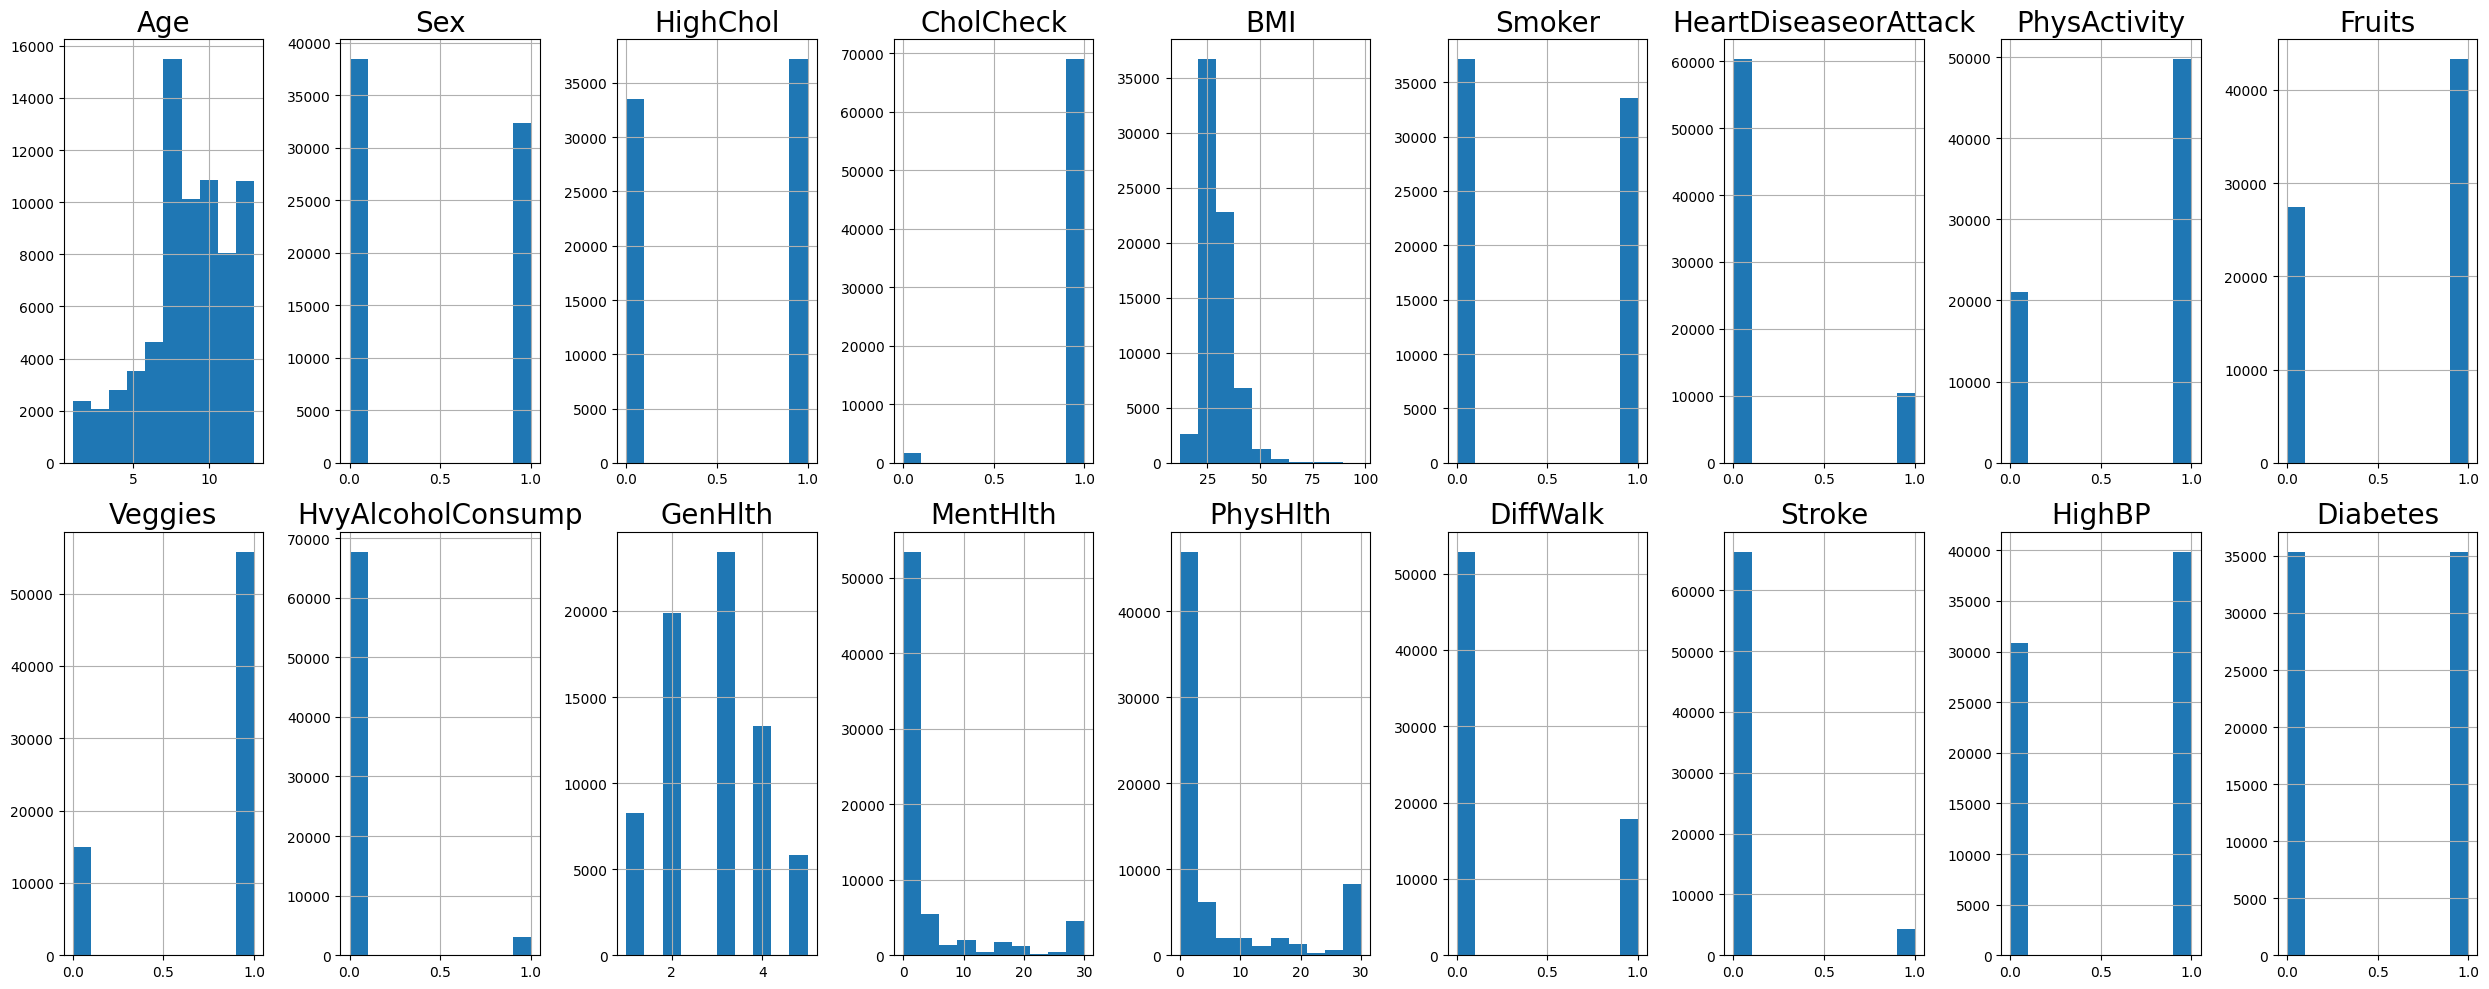

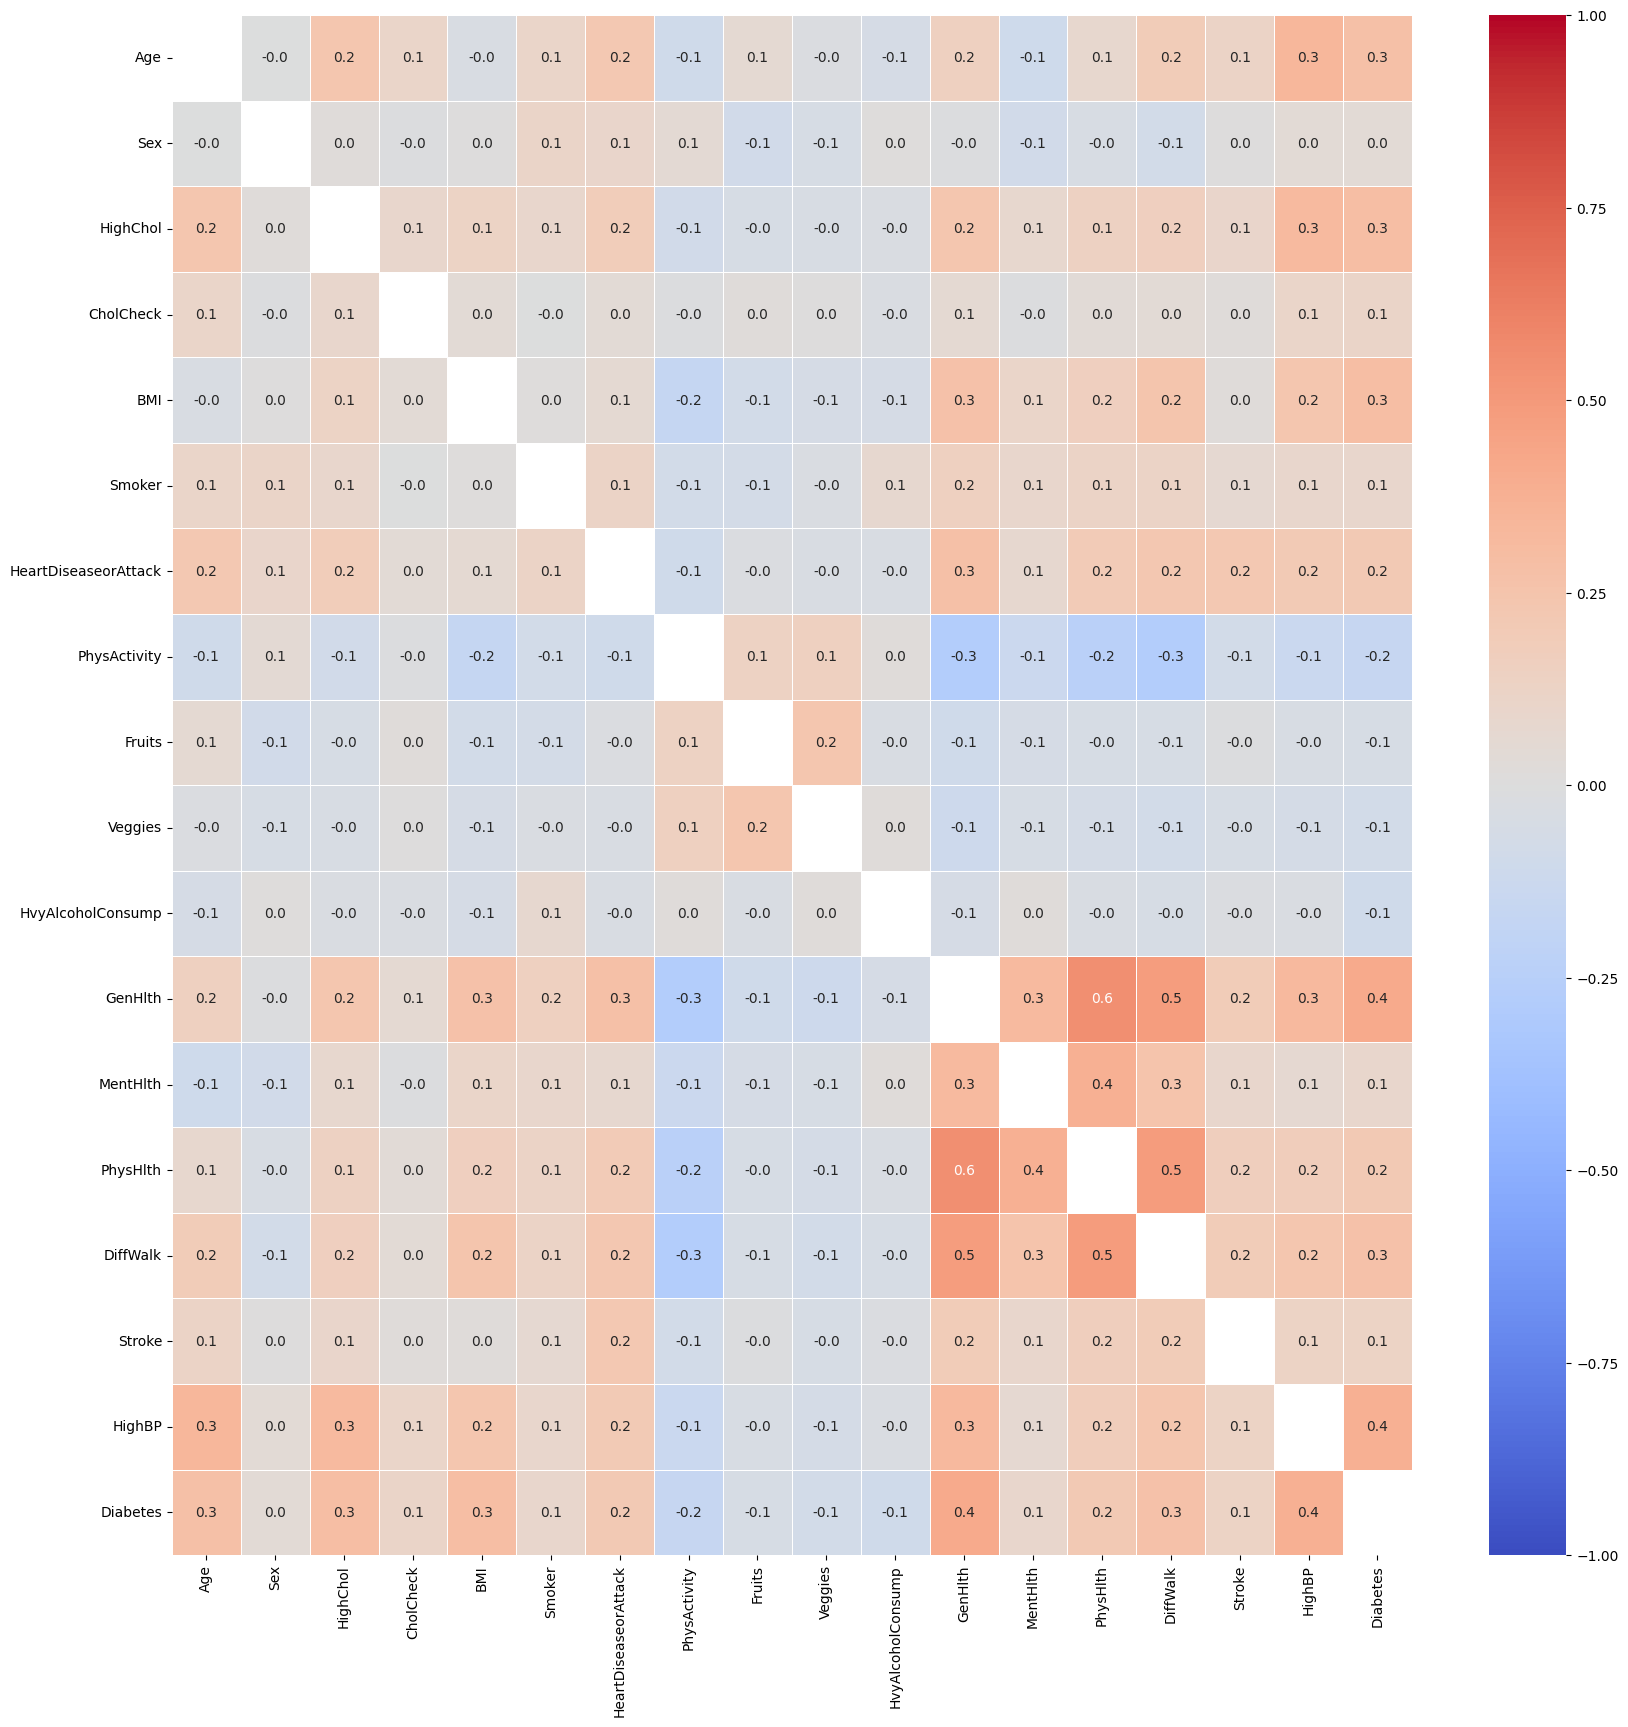

In [10]:
# EDA preliminar

# descripcion atributos numericos
display(df.describe().T)

# distribucion atributos numericos
plt.figure(figsize=(25,10))
for i, col in zip(range(df.shape[1]), df.columns) :
    plt.subplot(2,9,i+1)
    df[col].hist()
    plt.title(col, fontsize=20)
plt.tight_layout()
plt.show() ;

# matriz de correlacion atributos numericos
plt.figure(figsize=(20,20))
mat = df.corr(numeric_only=True)
sns.heatmap(mat[(mat!=1)], annot=True, vmin=-1, vmax=1, fmt=".1f", linewidth=.5, cmap='coolwarm')
plt.show() ;

  0%|          | 0/20 [00:00<?, ?it/s]

Número de trials: 20

Mejor trial:

- recall = 0.77

- Params: 
    learning_rate      = 0.02471373418487883
    n_estimators       = 322
    max_depth          = 4
    max_leaves         = 55
    min_child_weight   = 4
    reg_alpha          = 2.4257815076675944e-05
    reg_lambda         = 0.7016387837751591

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74      3570
         1.0       0.72      0.80      0.76      3500

    accuracy                           0.75      7070
   macro avg       0.75      0.75      0.75      7070
weighted avg       0.75      0.75      0.75      7070



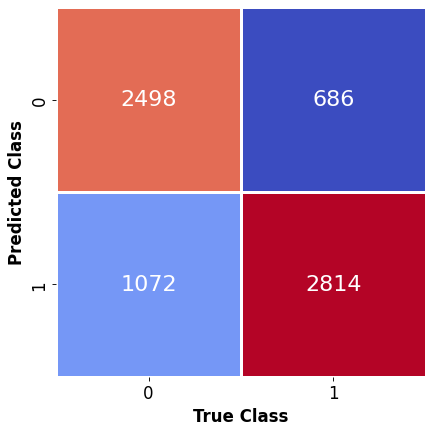

In [11]:
# Inserte su código aquí

# En base al EDA preliminar, durante el preprocesamiento se genera un pipeline
# para escalar los atributos numericos (el dataset no posee atributos categoricos),
# para luego ajustar el modelo XGBClassifier, cuyos hiperparametros son optimizados
# mediante optuna. Utilizando el mejor modelo, se realizan las predicciones sobre
# el conjunto de test y se genera el reporte de clasificacion y la matriz de confusion.

# Cabe señalar que, en virtud del EDA preliminar, podrían descartarse algunas variables
# con poca dispersión de datos (e.g. CholCheck y HvyAlcoholConsump) o con multicolinealidad
# (e.g. GenHlth-PhysHlth), sin embaro, a través del proceso de interpretabilidad del
# modelo se espera descartar dichas variables en caso no generen un aporte en las
# predicciones.


# particionamos los datos en train (70%), val (20%) y test (10%)
X = df.drop('Diabetes', axis=1)
y = df.Diabetes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-.7, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.1/(.1+.2), random_state=123)

# definimos la funcion objetivo
def objective(trial):

    # definimos parametros a optimizar para XGBClassifier
    params_XGBClassifier = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }

    # generamos pipeline y ajustamos el modelo
    pipe = Pipeline([('step1', ColumnTransformer(transformers=[('preprocess', MinMaxScaler(), X.columns)], remainder='drop')),
                     ('step2', XGBClassifier(seed=123, **params_XGBClassifier))])
    optuna_model = pipe.fit(X_train, y_train)

    # evaluamos las predicciones del modelo
    y_pred = optuna_model.predict(X_val)
    eval_metric = f1_score(y_val, y_pred)

    return eval_metric

# generamos estudio de optimizacion
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(sampler=TPESampler(seed=123), direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

# reporte de resultados
print('Número de trials: {}'.format(len(study.trials)))
print()
print('Mejor trial:')
trial = study.best_trial
print()
print(f'- recall = {trial.value:.2f}')
print()
print('- Params: ')
for key, value in trial.params.items():
    print(f'    {key:18.18s} = {value}')
print()

# ajustamos el modelo con los hiperparametros optimos
pipe = Pipeline([('step1', ColumnTransformer(transformers=[('preprocess', MinMaxScaler(), X.columns)], remainder='drop',
                                             verbose_feature_names_out=True)),
                 ('step2', XGBClassifier(seed=123, **study.best_params))])
model = pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)

# visualizamos el reporte de clasificacion
print(classification_report(y_test, y_pred))

# visualizamos la matriz de confusion
plt.figure(figsize=(10, 6), dpi=80)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            cmap='coolwarm', linewidth=1, annot_kws={'size':20})
plt.tick_params(labelsize=15)
plt.xlabel('True Class', fontweight='bold', fontsize=15)
plt.ylabel('Predicted Class', fontweight='bold', fontsize=15)
plt.show() ;

En relación a las preguntas de esta sección:

> ¿Es acaso un buen predictor de diabetes?

**R.** Si suponemos que un caso falso positivo de diabetes es menos severo que un caso falso positivo de cáncer, entonces podría argumentarse que el modelo implementado es un buen predictor de diabetes dado que el accuracy de las predicciones supera el 70 %. Cabe señalar que se alude el contraejemplo del cáncer puesto que, para dicha enfermedad, debiese esperarse un desempeño mayor (*i.e.* al menos un accuracy sobre el 90 %) dada la severidad de la enfermedad y las consecuencias de no detectarla en forma temprana.

> ¿Qué buscan explicar las métricas utilizadas?

**R.** Si bien en el reporte de clasificación se incluye la totalidad de las métricas, para el problema en estudio nos interesan los valores de Recall y F1-score. El primero permite explicar la capacidad del modelo para identificar todos los casos positivos de diabetes, mientras que el segundo permite explicar la capacidad general del modelo para identificar casos positivos de diabetes y, además, para no etiquetar como positivo un caso de diabetes que es negativo.

> ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?

**R.** Como se indicó en la primera respuesta, podría argumentarse que las métricas obtenidas son aceptables dado que el modelo es un buen predictor, sin embargo, dicha afirmación depende de la severidad con la que se considere la ocurrencia de diabetes en un paciente. Ahora bien, en cuanto a la elección de las features, no es claro, a partir de las métricas utilizadas para medir la predictibilidad, que el modelo realice una buena elección de las mismas.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

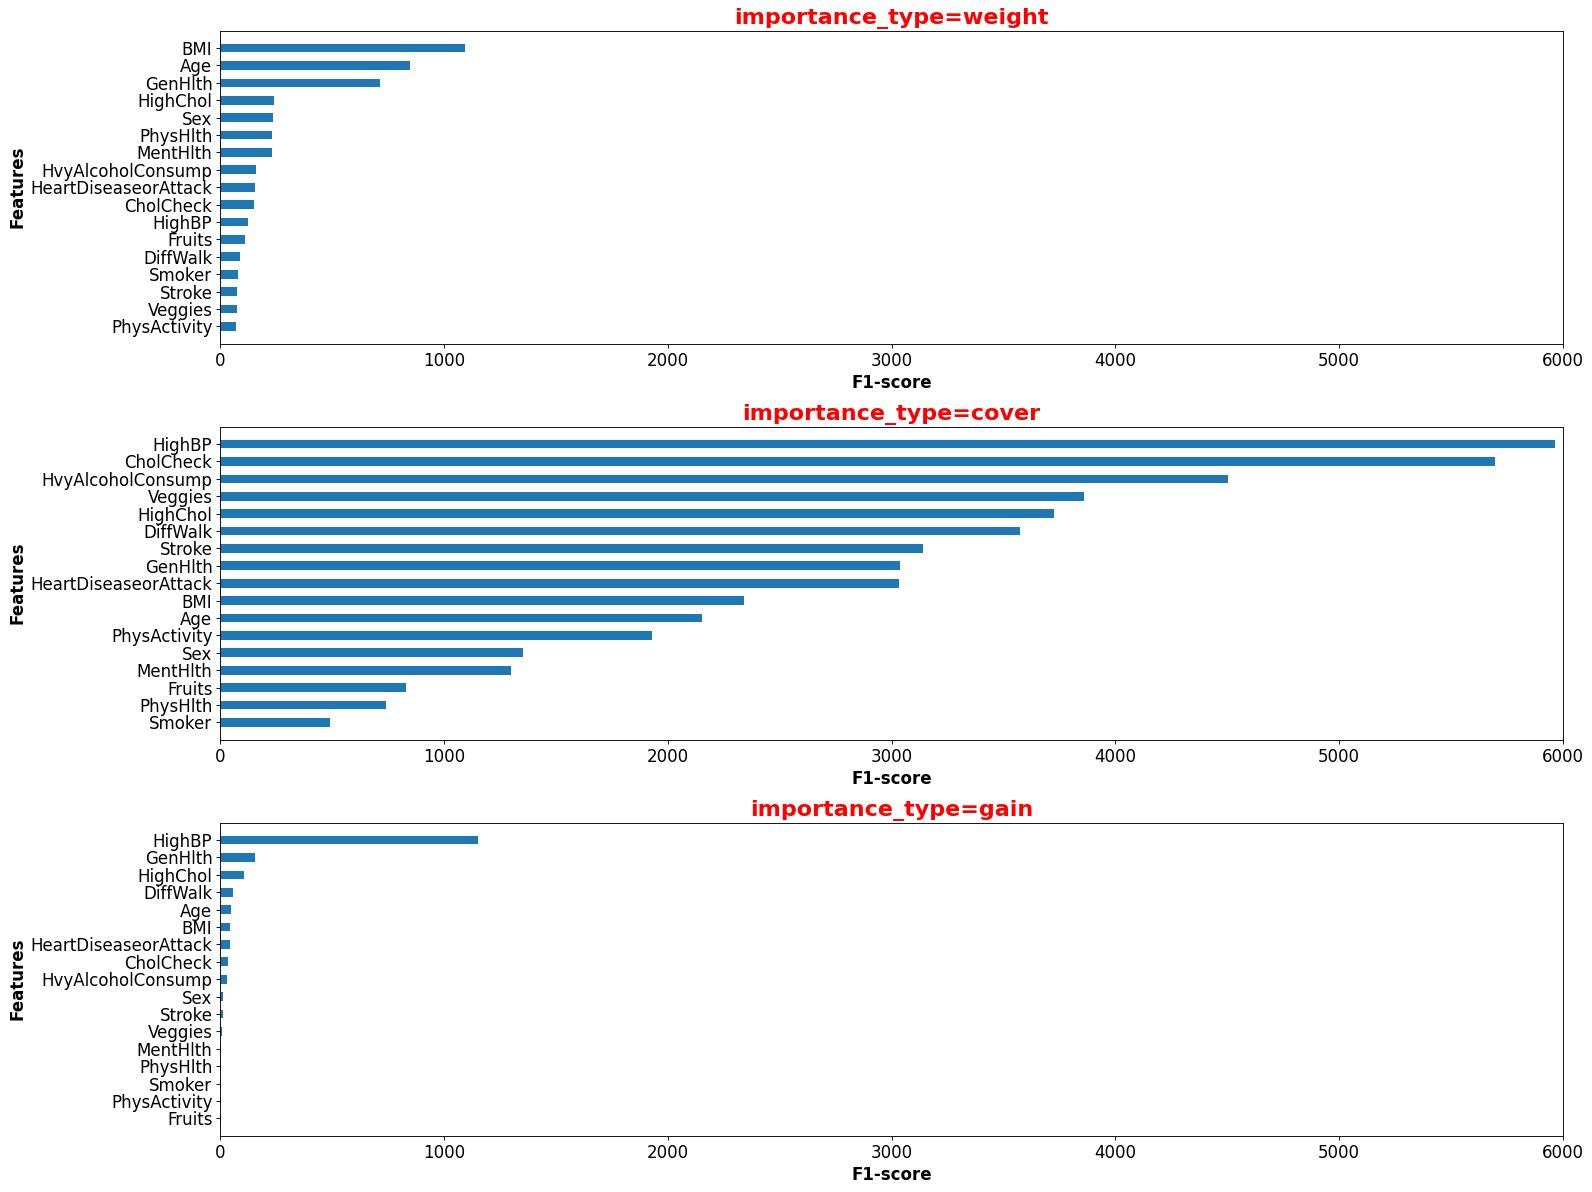

In [12]:
# Inserte su código aquí

# creamos un diccionario para mapear el nombre de las features en las visualizaciones
feature_names = {}
for i, col in zip(range(X.shape[1]), X.columns) :
    feature_names[f'f{i}'] = col

# visualizamos la importancia de las features
fig, ax = plt.subplots(3, 1, figsize=(20,15), dpi=80)

# importance_type=weight
plot_importance(model.steps[1][1], ax=ax[0], grid=False, title='', height=.5,
                importance_type='weight', show_values=False, xlim=(0,6000))
ax[0].tick_params(labelsize=15)
labels = pd.Series([ax[0].get_yticklabels()[i].get_text() for i in range(len(ax[0].get_yticklabels()))])
labels = labels.map(feature_names).tolist()
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('F1-score', fontweight='bold', fontsize=15)
ax[0].set_ylabel('Features', fontweight='bold', fontsize=15)
ax[0].set_title('importance_type=weight', fontweight='bold', fontsize=20, color='red')

# importance_type=cover
plot_importance(model.steps[1][1], ax=ax[1], grid=False, title='', height=.5,
                importance_type='cover', show_values=False, xlim=(0,6000))
ax[1].tick_params(labelsize=15)
labels = pd.Series([ax[1].get_yticklabels()[i].get_text() for i in range(len(ax[1].get_yticklabels()))])
labels = labels.map(feature_names).tolist()
ax[1].set_yticklabels(labels)
ax[1].set_xlabel('F1-score', fontweight='bold', fontsize=15)
ax[1].set_ylabel('Features', fontweight='bold', fontsize=15)
ax[1].set_title('importance_type=cover', fontweight='bold', fontsize=20, color='red')

# importance_type=gain
plot_importance(model.steps[1][1], ax=ax[2], grid=False, title='', height=.5,
                importance_type='gain', show_values=False, xlim=(0,6000))
ax[2].tick_params(labelsize=15)
labels = pd.Series([ax[2].get_yticklabels()[i].get_text() for i in range(len(ax[2].get_yticklabels()))])
labels = labels.map(feature_names).tolist()
ax[2].set_yticklabels(labels)
ax[2].set_xlabel('F1-score', fontweight='bold', fontsize=15)
ax[2].set_ylabel('Features', fontweight='bold', fontsize=15)
ax[2].set_title('importance_type=gain', fontweight='bold', fontsize=20, color='red')

plt.tight_layout()
plt.show() ;

En relación a las preguntas de esta sección:

> ¿Los resultados obtenidos con los diferentes métodos son compatibles? Comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados

**R.** En virtud de las gráficas generadas con los tres métodos, se observa que los resultados obtenidos no son compatibles entre sí, pues, difieren en la importancia asignada a las features.

La situación anterior se atribuye a la forma en que es calculada la importancia de las features en cada método: `weight` calcula la importancia como el número de veces que aparece una feature en un árbol, `gain` como la ganancia promedio de divisiones del árbol que utiliza la feature y `coverage` como la cobertura promedio de divisiones del árbol que utiliza la feature. Así, se reconoce que la importancia asignada a una cierta feature depende del tipo de método utilizado para evaluar la importancia de la variable predictora.

> ¿Las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles?

**R.** Se considera que las importancias obtenidas no son suficientes para analizar la interpretabilidad del modelo implementado debido a que no es claro qué features contribuyen más en las predicciones.

> ¿Qué debilidad presenta este método?

**R.** El método evaluado con XGBoost puede inducir a error en aquellos casos en los que las features posean muchos valores posibles, pues, dichas features pueden utilizarse con más frecuencia dado que hay más oportunidades para dividirlas en cada nodo del árbol de decisión.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

CholCheck            : 0.003 +/- 0.0005
HighBP               : 0.003 +/- 0.0004
HighChol             : 0.002 +/- 0.0005
PhysActivity         : 0.001 +/- 0.0004
HeartDiseaseorAttack : 0.001 +/- 0.0003
Stroke               : 0.000 +/- 0.0001


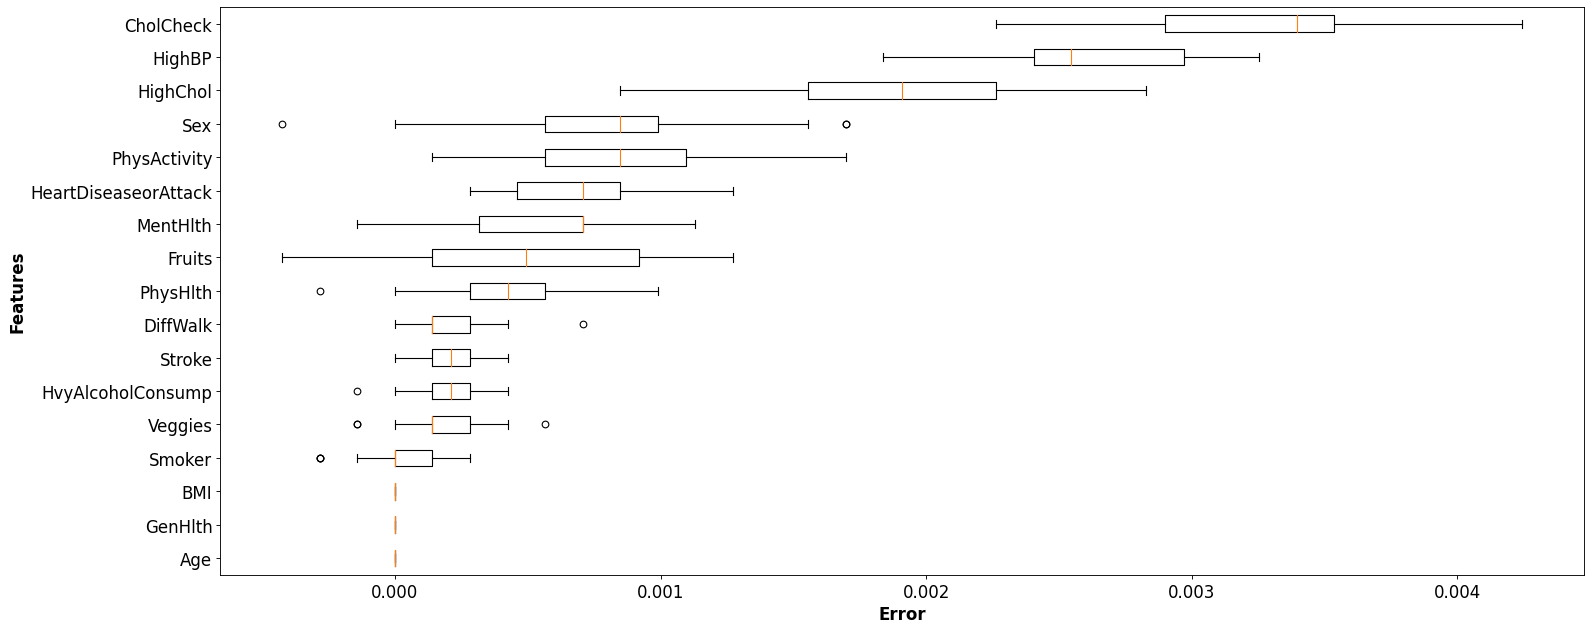

In [13]:
# Inserte su código aquí

# implementamos el metodo de permutacion
r = permutation_importance(model.steps[1][1], X_test, y_test, n_repeats=30, random_state=123)

# imprimimos resultados de la permutacion
for i in r.importances_mean.argsort()[::-1] :
    if r.importances_mean[i] - 2*r.importances_std[i] > 0 :
        print(f'{X.columns[i]:20.20s} : {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.4f}')

# visualizamos los resultados
fig, ax = plt.subplots(figsize=(20,8), dpi=80)
perm_sorted_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[perm_sorted_idx].T, vert=False, labels=X.columns[perm_sorted_idx])
ax.tick_params(labelsize=15)
ax.set_xlabel('Error', fontweight='bold', fontsize=15)
ax.set_ylabel('Features', fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show() ;

En relación a las preguntas de esta sección:

> Para que su modelo sea consistente, repita el proceso 30 veces y verifique la desviación estándar de sus resultados (¿Qué señala está?)

**R.** La desviación estándar representa la variabilidad asociada a la importancia asignada en cada una de las permutaciones de las features.

> ¿Cómo mide la importancia de las features su propuesta?

**R.** La importancia de las features es medida como la disminución en la importancia asignada cuando el valor de una cierta feature es mezclada de manera aleatoria.

> ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?

**R.** Las features de mayor impacto en la salida del modelo corresponden a `CholCheck`, `HighBP`, `HighChol`, `PhysActivity` y `HeartDiseaseorAttack`, las cuales tienen sentido ya que, luego de una revisión bibliográfica, se reconoce que la diabetes se asocia a un colesterol alto y/o presión sanguínea alta, enfermedades cardíacas y bajo nivel de actividad física.

> ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?

**R.** En virtud de los resultados obtenidos, se concluye que el método de permutación permite obtener importancias suficientes para analizar la explicabilidad del modelo implementado, siendo de mayor claridad, respecto a la sección anterior, qué features contribuyen más en las predicciones.

> Nombre y explique 3 ventajas y 3 desventajas del método implementado

**R.** Las principales ventajas del método de permutación, por un lado, incluyen la facilidad de interpretación sobre la importancia de las features en el modelo, el prescindir del re-entrenamiento del modelo para evaluar las importancias y la comparabilidad con diferentes modelos de aprendizaje (dado su carácter agnóstico). Las principales desventajas, por otro lado, incluyen la generación de sesgos si existe multicolinealidad  entre las features, la necesidad de acceso a los datos etiquetados (*i.e.* el resultado real) y la dependencia del método al error de predicción del modelo.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [14]:
# !pip install shap

In [15]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [16]:
# Inserte código para calcular shapley values aquí

# ajustamos el explainer
explainer = shap.TreeExplainer(model.steps[1][1])

# calculamos los shap values
shap_values = explainer(X)

# imprimimos los resultados
shap_values

[21:46:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[ 0.33237004,  0.09058972, -0.23882271, ..., -0.03350654,
        -0.00513251,  0.3853098 ],
       [ 0.18735445,  0.06987236,  0.18060951, ..., -0.03949233,
         0.0492311 ,  0.38369727],
       [ 0.42481092,  0.0896317 , -0.20118052, ..., -0.02299945,
        -0.0051302 , -0.49911526],
       ...,
       [ 0.15283327, -0.0654007 ,  0.16667694, ...,  0.1445208 ,
        -0.00418781,  0.3876587 ],
       [ 0.14945243, -0.06298152,  0.21486647, ...,  0.1194066 ,
        -0.00288526,  0.4006957 ],
       [ 0.10422121, -0.05880198,  0.14692757, ..., -0.05045301,
        -0.00372314,  0.365669  ]], dtype=float32)

.base_values =
array([0.00655608, 0.00655608, 0.00655608, ..., 0.00655608, 0.00655608,
       0.00655608], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.,  1.]

En relación a las preguntas de esta sección:

> ¿Qué representa cada número en su resultado?

**R.** Los números en el resultado obtenido representan los shap values (*i.e.* la importancia asignada a las features) y el valor base (*i.e.* el valor esperado de la salida del modelo si no tuviera información sobre las features).

> ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

**R.** El significado de la positividad/negatividad de cada valor está asociado al valor base mencionado en la respuesta anterior y a partir del cual se dispone de un punto de referencia que permite comprender si una feature dada contribuye de manera positiva/negativa en las predicciones del modelo.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [17]:
# Inserte código para generar gráficos de aporte local aquí

idx = 1
# explicar predicción idx 1
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx-1,:],
                X.iloc[idx-1,:],
                link="logit")

In [18]:
idx = 9
# explicar predicción idx 9
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx-1,:],
                X.iloc[idx-1,:],
                link="logit")

In [19]:
idx = 150
# explicar predicción idx 150
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx-1,:],
                X.iloc[idx-1,:],
                link="logit")

En relación a las preguntas de esta sección:

> ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?

**R.** Las variables que afectan de manera positiva a la probabilidad de poseer diabetes son `Age`, `BMI`, `GenHlth` y `Sex=1`, mientras que las variables que afectan de manera negativa son `HighChol=0`, `HighBP=0` y `Sex=0`.

> ¿Existe algún patrón común entre las instancias analizadas?

**R.** Se reconoce un patrón común en el que ciertas features se repiten e inciden, de manera recurrente, en la probabilidad de ocurrencia de diabetes en los pacientes del dataset en estudio, como ocurre con `BMI`, `Age` y `GenHealth`.

> ¿Es posible generalizar estas conclusiones a todo el dataset?

**R.** No es posible generalizar las conclusiones anteriores dado que se debiese considerar una muestra mayor de pacientes (no sólo tres instancias) para analizar la interpretabilidad del modelo implementado.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

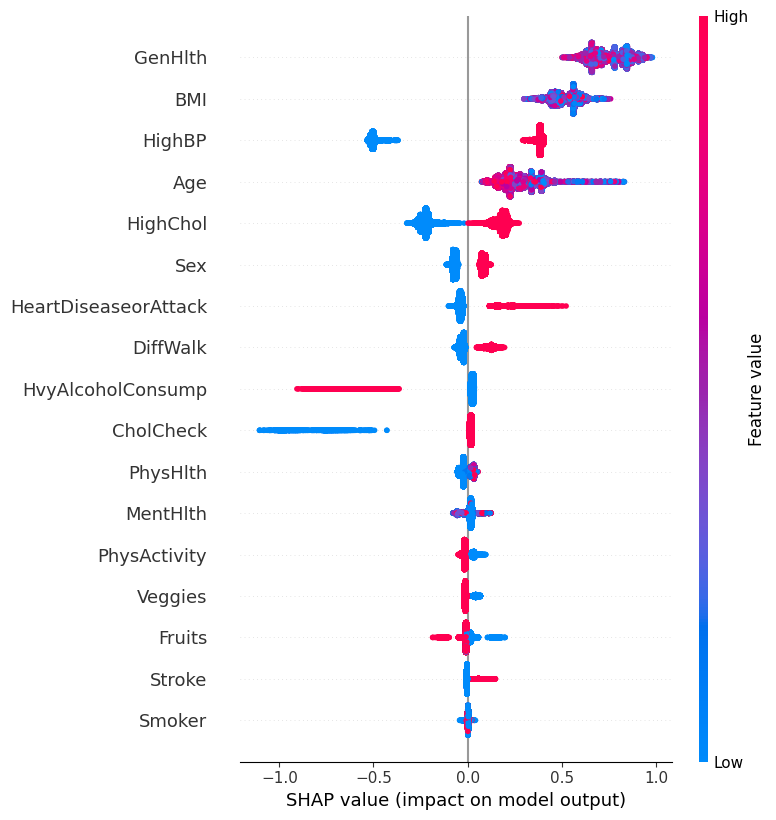

In [20]:
# Inserte código para generar gráficos de aporte global aquí

shap.summary_plot(shap_values)

En relación a la pregunta de esta sección:

> ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

**R.** A nivel global, se desprenden las mismas conclusiones observadas a nivel de instancia *i.e.* las variables que afectan de manera positiva a la probabilidad de poseer diabetes son `Age`, `BMI`, `GenHlth` y `Sex`, mientras que las variables que afectan de manera negativa son `HighChol`, `HighBP` y `HvyAlcoholConsump`. De manera complementaria, se reconoce que las cinco variables de mayor impacto en las predicciones son `GenHlth`, `BMI`, `HighBP`, `Age` y `HighChol`.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

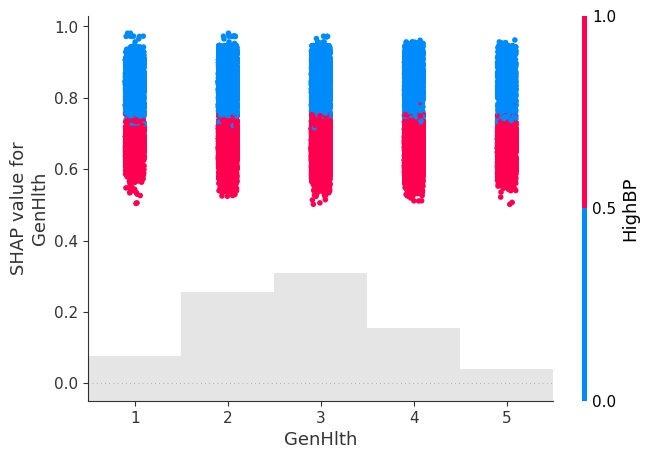

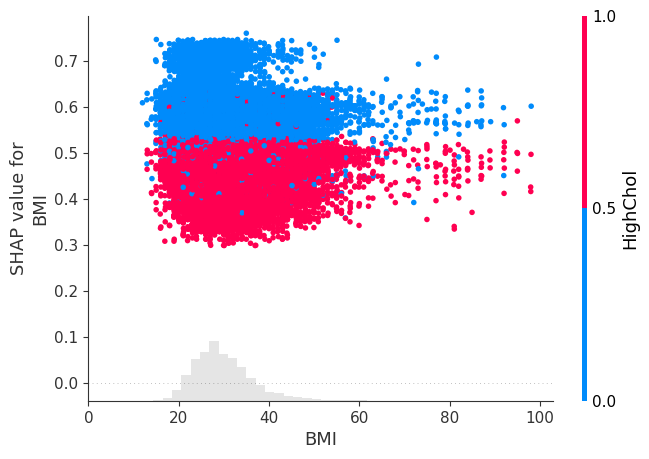

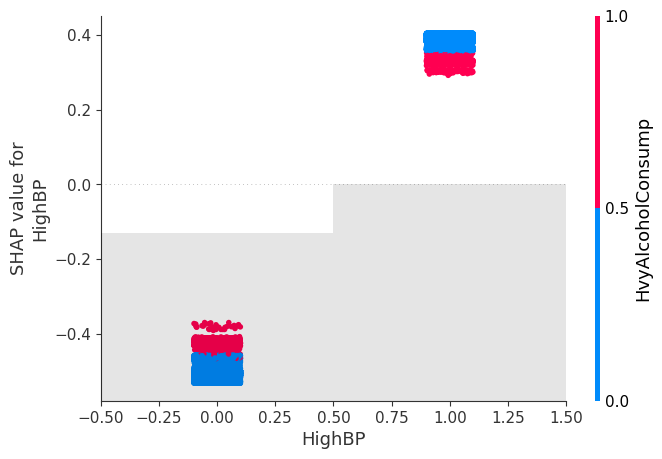

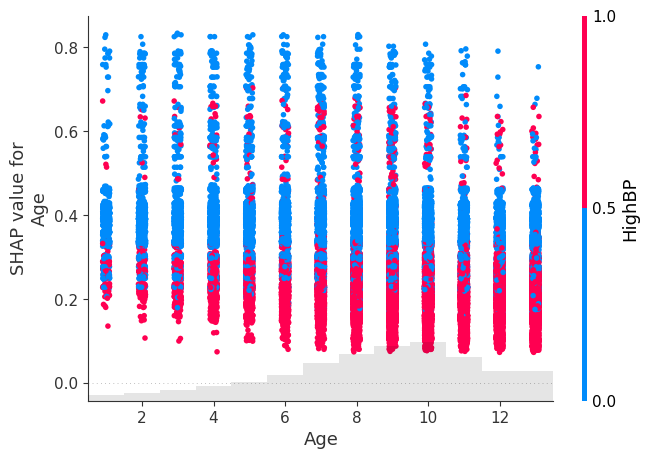

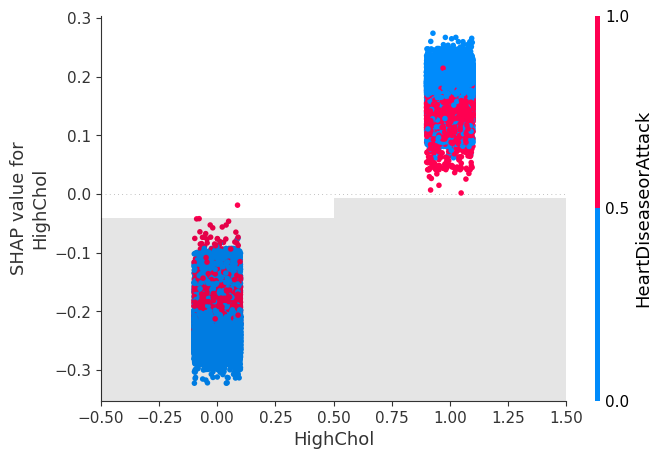

In [21]:
# Inserte código para generar gráficos de feature vs shap value aquí

# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# visualizamos los diagramas de dispersion
for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name], color=shap_values, xmin=0)

En relación a la pregunta de esta sección:

> ¿Qué puede concluir de sus resultados?

R: Los gráficos muestran los Shap Values asignados a cada observación, coloreados en función del valor en otro predictor. Esto permite observar que los Shap values de cada atributo no son siempre los mismos para todas las personas según los valores que puedan tomar en otros atributos.

Se presentarán algunas interpretaciones para cada gráfico:

1) Se observa que cuando la presión arterial es alta (`HighBP=1`), el shap value de edad disminuye notablemente. Esto significa que cuando hay presión arterial alta la edad tiene menos importancia en la predicción que cuando la presión arterial no es alta.

2) Algo similar se observa en el gráfico 2, donde la importancia del `BMI` disminuye cuando la persona cuenta con antecedentes de colesterol alto (`HighChol=1`).

3) La importancia de alta presión arterial (`HighBP=1`) disminuye en presencia de consumo severo de alcohol (`HvyAlcoholConsump=1`).

4) Similar al caso 2, cuando hay antecedentes de presión arterial alta (`HighBP=1`), la importancia de la edad sobre la predicción disminuye sistemáticamente para todas las edades.

5) Finalmente, la importancia de los antecedentes de colesterol alto (`HighChol=1`) disminuye en presencia de antecedentes de enfermedad cardíaca (`HeartDiseaseorAttack=1`).

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

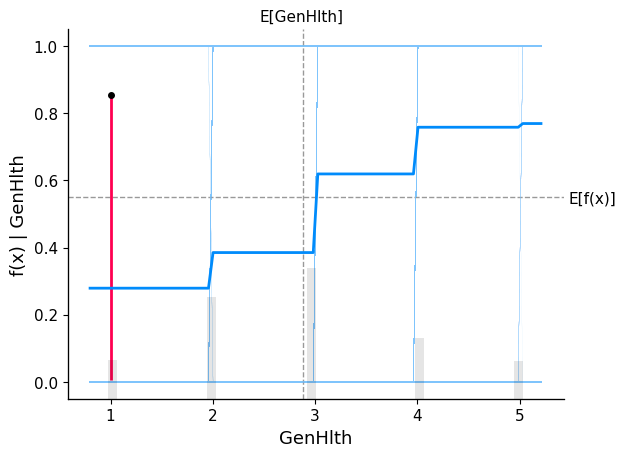

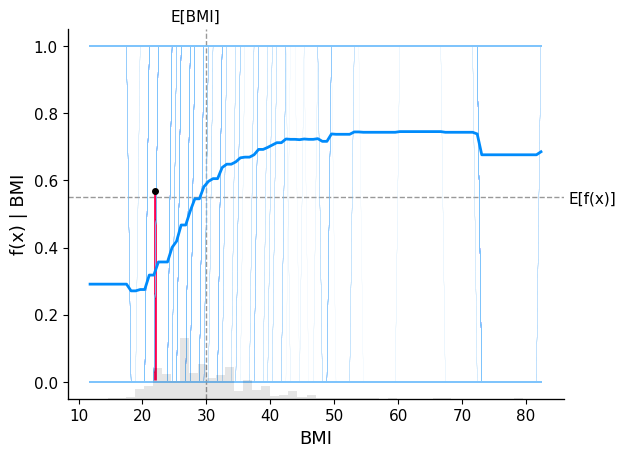

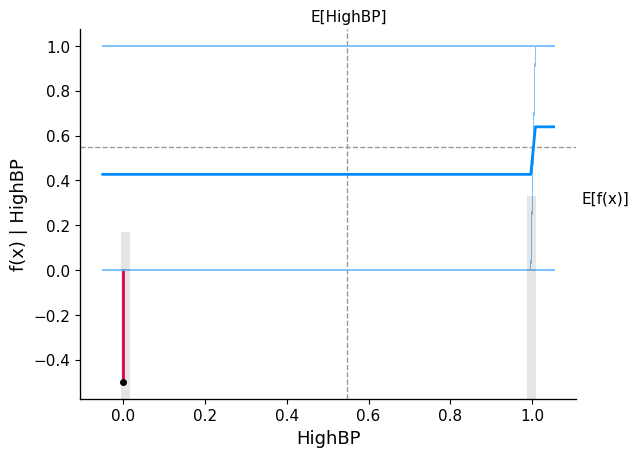

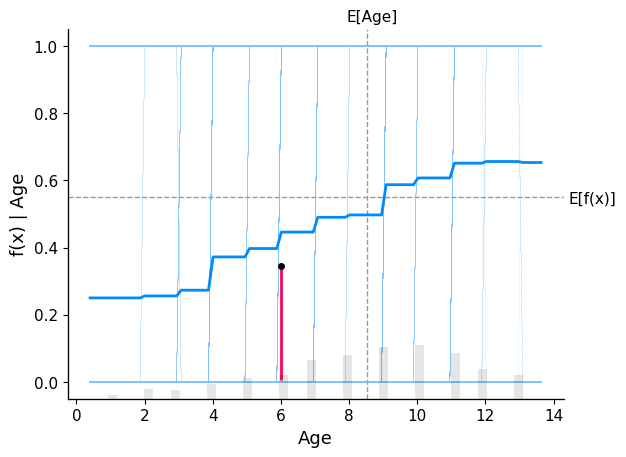

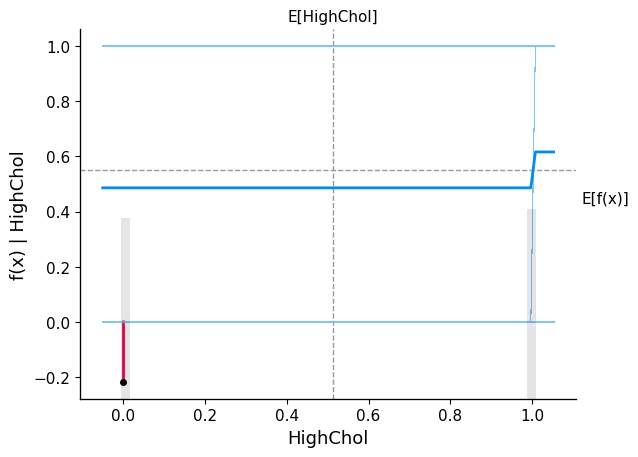

In [ ]:
# Inserte código para generar gráficos PDP aquí

# extraemos la submuestra
X1000 = shap.utils.sample(X, 1000, random_state=123)
sample_ind = 20

# generamos los graficos de dependencia parcial
for name in feature_importance_names[:5]:
  shap.partial_dependence_plot(
      name, pipe.predict, X1000, model_expected_value=True,
      feature_expected_value=True, ice=True,
      shap_values=shap_values[sample_ind:sample_ind+1,:]
      )

En relación a las preguntas de esta sección:

> ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?

R: La salida promedio del modelo en cada gráfico corresponde al promedio de la predicción que el modelo hace con un feature en específico, manteniendo los demás constantes. Esto permite explorar, de forma simplificada, la relación entre el feature aislado y la predicción del modelo. En este caso, para cada gráfico tenemos que:

1) Hay una relación directa entre la percepción de salud general `GenHlth` y la predicción de diabetes.

2) Hay también una relación directa entre `BMI` y la predicción de diabetes. Sin embargo, la importancia del `BMI` se estabiliza y deja de aumentar a partir de `BMI=50` aproximadamente.

3) Se observa un aumento en la predicción de diabetes cuando hay antecedentes de presión arterial alta (`HighBP=1`).

4) También se observa una relación directa entre la edad y la predicción de diabetes, con una relación relativamente lineal (con aumentos no muy distintos entre categorías consecutivas). Esto en contraste con el comportamiento observado en BMI, donde había un incremento en la probabilidad de predecir diabetes, pero a partir de `BMI=50` dicha relación se atenuaba considerablemente.

5) Los antecedentes de colesterol alto (`HighChol=1`) se asocian a una mayor predicción de diabetes.

> ¿Son estas conclusiones generalizables para todo el conjunto de datos?

A partir de las características de los dependence plots, en principio podríamos decir que estas relaciones son de caracter más global que local, ya que buscan representar el efecto marginal de un atributo al mantener los demás constantes y no se basan en el resultado de una observación particular.

Sin embargo, la interpretación de estos gráficos asume que los atributos son independientes entre sí, por lo que la generalización de las conclusiones de los dependence plots dependerá de si los atributos del modelo interactúan o no.

En este caso, los scatterplots del ejercicio anterior nos mostraron diversas interacciones entre atributos, los cuales tenían efecto sobre los shap values de cada uno. Dado lo anterior, habría que tener mucho cuidado al intentar generalizar los resultados de los dependence plots al comportamiento global del modelo. Sin embargo, siguen siendo útiles para comprender, de manera simplificada, la relación entre el atributo y el outcome.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
# !pip install alibi

In [ ]:
# from alibi.explainers import AnchorTabular

In [ ]:
# Inserte su código para generar sistema de reglas aquí

# inicializamos y ajustamos el modelo con los hiperparametros optimos
X = df.drop('Diabetes', axis=1)
y = df.Diabetes
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-.7, random_state=123)
clf = XGBClassifier(seed=123, **study.best_params)
clf.fit(X_train, y_train)

# ajustamos el explainer
predict_fn = lambda x: clf.predict(x)
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())
class_names = ["normal", "diabetes"]

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx-1], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx-1].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print()

idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx-1], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx-1].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print()

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx-1], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx-1].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  normal
Anchor: GenHlth <= 0.25 AND HighBP <= 0.00
Precision: 0.95
Coverage: 0.26

Prediction:  normal
Anchor: GenHlth <= 0.25 AND HighBP <= 0.00
Precision: 0.97
Coverage: 0.25

Prediction:  diabetes
Anchor: GenHlth > 0.25 AND DiffWalk > 0.00 AND BMI > 0.20
Precision: 0.97
Coverage: 0.14


En relación a las preguntas de esta sección:

> Con las reglas propuestas señale a cuánta población es posible explicar con estas reglas e indique la precisión que poseen las reglas en la totalidad de los datos.

R: Para la primera y segunda regla que predicen un diagnóstico "normal", con precisiones del 95% y 97% y coberturas del 26% y 25% respectivamente, es posible explicar a aproximadamente un cuarto del conjunto de datos.

Para la tercera regla que predice "diabetes", con una precisión del 97% y una cobertura del 14%, se puede explicar aproximadamente un 14% del total del conjunto de datos.

> ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos

R: Las reglas tienen sentido al compararlas con los resultados de los ejercicios anteriores, donde `BMI`, `GenHlth` y `HighBP`, además de `DiffWalk` (identificado en el summary plot). Sin embargo, estas reglas no alcanzan a explicar más de 1/4 de la totalidad de los datos por lo que, si bien son altamente confiables, no son representativas de lo que ocurre en la mayoría de los casos.

Pese a ello, se reconoce el valor de conocer estas reglas, pues ayudan a poder explicar mejor cuáles son los atributos más importantes para el modelo a la hora de realizar la clasificación.


# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

A nuestro parecer, los métodos que permiten entregar las mejores conclusiones corresponden al **método de permutación** y **SHAP values**, puesto que permiten identificar aquellas features que, de acuerdo con lo reportado en la bibliografía médica, inciden en la ocurrencia de diabetes. Esto ofrece coherencia con respecto a la literatura disponible y el conocimiento general sobre diabetes.

Ahora bien, se considera que los métodos agnósticos locales pueden ser más útiles para el problema del Doctor Simi. Esto ya que su objetivo no es sólo usar ML para apoyar el diagnóstico de diabetes, sino también poner el foco en la interpretabilidad de los modelos. En otras palabras, es importante en este caso ser capaces de explicar las decisiones que el modelo está tomando.

Los métodos globales ayudan a comprender el aporte general de cada atributo al diagnóstico de diabetes. Sin embargo, si el objetivo es explicar por qué un determinado paciente fue diagnosticado o no con diabetes por el modelo es algo que se puede lograr mucho mejor con métodos agnósticos locales, los cuales ofrecen detalles acerca de cómo el modelo ha ponderado cada atributo y cuáles han sido más importantes en la decisión que tomó.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>